In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

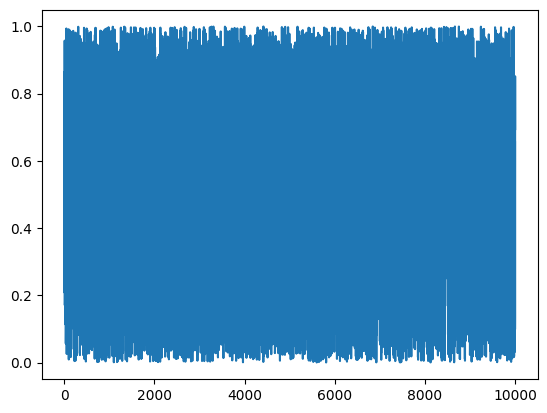

In [6]:
n = 200
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
#  we let r=25
r = 10
y = np.zeros(n) #initialising y array
sigmay = 0.1
for i in range(n):
    yTemp = X[i][0:r].sum() + np.random.normal(0, sigmay) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [3]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta[i] = 1                                
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])

    # print("Number of samples is" % str(len(samples)))
    return np.asarray(samples)


# trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

In [4]:
@jit
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

@jit
def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

@jit
def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

@jit
def ssp(theta, gamma, X, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [5]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    # theta_0 = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1))
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(theta_0.T[0], np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, X, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, X, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas


# samples = metroHastings(sigma1 = 1, sigma2 = 0.01, sigmay = 0.01, sigma_theta = 1, X = X, y = y, niter = 50000)
# samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, sigma_theta = 1, X = X, y = y, niter = 100000)

tf.Tensor(
[ 9.30949688e-01  9.66710389e-01  9.73419368e-01  9.60812569e-01
  9.45499778e-01  8.70284081e-01  9.47811007e-01  9.44620311e-01
  9.23714697e-01  9.56215262e-01 -2.12867353e-02  4.08908501e-02
 -1.82104949e-02  6.16669934e-03  7.91639388e-02  3.47306095e-02
  1.23204915e-02  2.91239582e-02  2.24793851e-02  4.93728742e-02
 -1.93493180e-02  6.78012753e-03 -3.08042229e-03  7.14421924e-03
  5.67941517e-02  4.06545363e-02  1.57722253e-02 -2.70181242e-02
  4.69596572e-02 -2.68307906e-02 -1.62875485e-02 -1.00178281e-02
 -4.24571969e-02  3.63374054e-02  2.98195109e-02  8.54327343e-03
  3.31612900e-02 -1.75372921e-02 -3.03387027e-02 -1.46987587e-02
  1.49204899e-02  1.35970712e-02  7.08135366e-02  2.55588628e-03
  2.17187107e-02 -8.66917137e-04  1.79701671e-02  5.67231253e-02
  3.31043005e-02  1.40986275e-02], shape=(50,), dtype=float32)


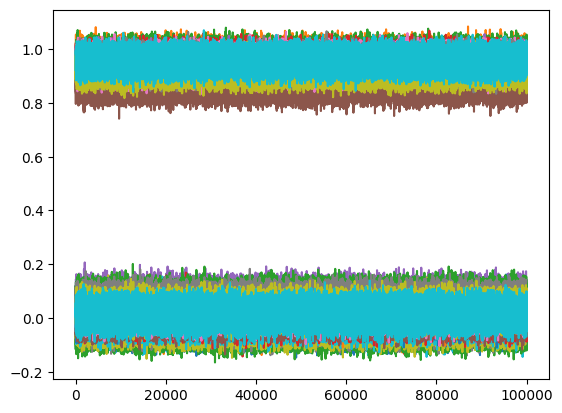

In [7]:
traceSGS = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, X = X, y = y, niter = 100000)

sampleSGS = tf.convert_to_tensor(traceSGS, dtype=tf.float32)
plt.plot(sampleSGS)
meanSGS, varianceSgs = tf.nn.moments(sampleSGS, axes=0)
print(meanSGS)

C:\Users\Johnny Lee\AppData\Local\Temp\ipykernel_22976\2984268999.py:16: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ssp" failed type inference due to: No implementation of function Function(<built-in function iadd>) found for signature:
 
 >>> iadd(Literal[int](0), array(float64, 1d, C))
 
There are 18 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'iadd': File: <numerous>: Line N/A.
    With argument(s): '(int64, array(float64, 1d, C))':
   No match.
  - Of which 2 did not match due to:
  Operator Overload in function 'iadd': File: unknown: Line unknown.
    With argument(s): '(int64, array(float64, 1d, C))':
   No match for registered cases:
    * (int64, int64) -> int64
    * (int64, uint64) -> int64
    * (uint64, int64) -> int64
    * (uint64, uint64) -> uint64
    * (float32, float32) -> float32
    * (float64, float64) -> float64
    * (complex64, complex64) -> complex64
    * (com

Acceptance Rate is 0.06278, with total number of acceptance of 3139
tf.Tensor(
[ 9.67726231e-01  1.01453972e+00  1.02689254e+00  9.83400166e-01
  9.77516174e-01  9.45273817e-01  1.00469315e+00  9.85444427e-01
  9.91941869e-01  9.83878911e-01 -2.45151166e-02  4.20739204e-02
 -9.88299306e-03 -1.05647035e-02  4.21238244e-02 -1.02200976e-03
 -5.98319806e-03  2.57239048e-03  1.57955457e-02  5.51054627e-02
 -2.08569821e-02 -7.75456475e-03 -1.96374301e-02 -8.97948258e-03
  1.49132973e-02  7.69159431e-03 -1.79761499e-02 -2.35779006e-02
  2.89690923e-02 -4.19504754e-02 -3.19298431e-02 -1.84035469e-02
 -5.35326190e-02  2.63871551e-02 -7.53887347e-04  1.78516656e-02
  9.54222400e-03 -2.04912107e-02 -1.18923485e-02 -5.15150204e-02
 -1.52395421e-03  9.10823885e-03  6.02348037e-02 -9.93363000e-03
  1.86156500e-02  1.19572673e-02  1.93486344e-02  5.22595607e-02
  1.17751760e-02  2.24908981e-02], shape=(50,), dtype=float32)


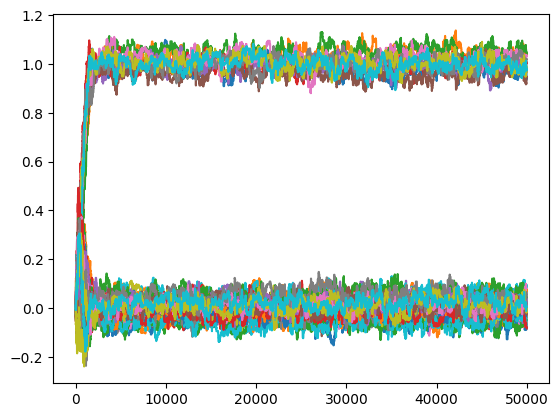

In [8]:
traceMh = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, sigma_theta = 0.0001, X = X, y = y, niter = 50000)
sampleMh = tf.convert_to_tensor(traceMh, dtype = tf.float32)
plt.plot(sampleMh)
# mean-mh, variance = tf.nn.moments(trace, axes=0)
meanMh = tf.math.reduce_mean(sampleMh, axis=0)
print(meanMh)